In [1]:
from __future__ import print_function
import glob
from itertools import chain
import os
import cv2
import csv
import random
import zipfile
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from functools import reduce
import torch.nn as nn
from einops import rearrange, repeat
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import pandas as pd
from torchvision.transforms import ToPILImage
# from linformer import Linformer
from PIL import Image
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
# from vit_pytorch.efficient import ViT
# from model import BiSeNet
import torchvision.transforms as transforms
from skimage import io, img_as_float
import timm
from sklearn.metrics import log_loss, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt


In [2]:
from TimeSformer.timesformer.models.vit import TimeSformer

In [3]:
seed = 17
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [4]:
device = 'cuda'
# device = 'cpu'

In [5]:
fakeavceleb_paths_df = pd.read_csv('File_Path_Dictionaries/fakeavceleb_paths.csv')
celebdf_paths_df = pd.read_csv('File_Path_Dictionaries/celebdf_paths.csv')
dfdc_paths_df = pd.read_csv('File_Path_Dictionaries/dfdc_paths.csv')
faceswap_paths_df = pd.read_csv('File_Path_Dictionaries/ff_paths.csv')

video_fakeavceleb_paths_df = pd.read_csv('Video_File_Path_Dictionaries/fakeavceleb_paths.csv')
video_celebdf_paths_df = pd.read_csv('Video_File_Path_Dictionaries/celebdf_paths.csv')
video_dfdc_paths_df = pd.read_csv('Video_File_Path_Dictionaries/dfdc_paths.csv')
video_faceswap_paths_df = pd.read_csv('Video_File_Path_Dictionaries/ff_paths.csv')

In [6]:
test_set_paths_dictionary = {
                            'FakeAVCeleb': [fakeavceleb_paths_df['Path'], fakeavceleb_paths_df['Label']], 
                            'DFDC': [dfdc_paths_df['Path'], dfdc_paths_df['Label']],
                            'CelebDFV2': [celebdf_paths_df['Path'], celebdf_paths_df['Label']],
                            'FaceForensics': [faceswap_paths_df['Path'], faceswap_paths_df['Label']]
                            }

video_test_set_paths_dictionary = {
                            'FakeAVCeleb': [video_fakeavceleb_paths_df['Path'], video_fakeavceleb_paths_df['Label']], 
                            'DFDC': [video_dfdc_paths_df['Path'], video_dfdc_paths_df['Label']],
                            'CelebDFV2': [video_celebdf_paths_df['Path'], video_celebdf_paths_df['Label']],
                            'FaceForensics': [video_faceswap_paths_df['Path'], video_faceswap_paths_df['Label']]
                            }

In [17]:
import timm
models = ['swin_base_patch4_window7_224', 'xception', 'res2net101_26w_4s', 'tf_efficientnet_b7_ns', 'vit_base_patch16_224', 
          'mvitv2_base', 'ResNet', 'TimeSformer']
augs = ['No_Augmentations', 'Random_Cut_Out_Augs', 'Face_Cut_Out_Augs']
datasets = ['FakeAVCeleb', 'FaceForensics', 'DFDC', 'CelebDFV2']


In [18]:
def Evaluate(model, vids_path_dict, dataset):
    
    imgs_path = vids_path_dict[dataset][0]
    count = 0
    labels_map = ["fake", "real"]
    predictions = {}
    probs = {}
    for img in imgs_path:

        originallabel = None
        if 'fake' in img.split('/')[-3]:
            originallabel = 0
        elif 'real' in img.split('/')[-3]:
            originallabel = 1

        count+=1
        print(count)
        image = img.replace('\\','/')
        img = Image.open(image)
        tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
               transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        img = tfms(img)
        with torch.no_grad():
            outputs = model(img.unsqueeze(0).to(device))

        predicted_prob = []
        predicted_label = None
        for idx in torch.topk(outputs[0], k=1).indices.tolist():
            prob = torch.softmax(outputs[0], 0)[idx].item()

        if labels_map[idx] == 'fake':
            predicted_prob = 1 - prob
            predictions[image] = [predicted_prob, 0, originallabel]
        else:
            predicted_prob = prob
            print(predicted_prob)
            predictions[image] = [predicted_prob, 1, originallabel]
        print('--------------')
    
    torch.cuda.empty_cache()
    return predictions

def Video_Evaluate(model, vids_path_dict, dataset):
    videos = vids_path_dict[dataset][0]
    count = 0
    labels_map = ["fake", "real"]
    predictions = {}
    probs = {}
    tfms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
    for vid in videos:
        fake_prob = 0
        real_prob = 0
        originallabel = None
        if 'fake' in vid.split('/')[-2]:
            originallabel = 0
        elif 'real' in vid.split('/')[-2]:
            originallabel = 1
        count+=1
        print(count)
        images = sorted(glob.glob(vid + '/*.png'))
        images = [path.replace('\\','/') for path in images]
        concated_images_per_video = torch.zeros(1, 3, 224, 224)
        for i in range(8):
            img_path = images[i]
            img = Image.open(img_path)
            img_transformed = tfms(img)
            img_transformed = img_transformed.unsqueeze(0)
            concated_images_per_video = torch.cat((concated_images_per_video, img_transformed), dim=0)
        concated_images_per_video = concated_images_per_video[1:]
        concated_images_per_video = concated_images_per_video.permute(1, 0, 2, 3)
        with torch.no_grad():
            outputs = model(concated_images_per_video.unsqueeze(0).to('cuda'))
        predicted_prob = []
        predicted_label = None
        for idx in torch.topk(outputs[0], k=1).indices.tolist():
            prob = torch.softmax(outputs[0], 0)[idx].item()
        if labels_map[idx] == 'fake':
            predicted_prob = 1 - prob
            print(predicted_prob)
            predictions[vid] = [predicted_prob, 0, originallabel]
        else:
            predicted_prob = prob
            print(predicted_prob)
            predictions[vid] = [predicted_prob, 1, originallabel]
        print('--------------')
    torch.cuda.empty_cache()
    return predictions
    #     break

In [19]:
from aquarel import load_theme, Theme
plot_colors = ["#fc358f", "#EEA47FFF", '#101820FF', '#FEE715FF', '#AA96DA', '#317773', '#990011FF', '#00FFFF']
theme = (
    Theme(name="scientific")
    .set_grid(draw=True, width=0.5)
#     .set_font(family="monospace")
    .set_color(palette=plot_colors, plot_background_color="#FFFDFB")
)

In [1]:
for dataset in datasets:
    for model_name in models:
        # Load model weights
        PATH = '../model_weights/supervised_models/' + model_name + '/' + augs[1] + '/' + dataset + '/' + '/'
        for file in os.listdir(PATH):
            if file.endswith(".pth"):
                model_path = os.path.join(PATH, file)
                model_path = model_path.replace("//", "/")
                print(model_path)
                if model_name == 'ResNet':
                    model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', model_num_class=2)
                    model.load_state_dict(torch.load(model_path), strict=True)
                    model.to(device)
                    model.eval()
                    print("loaded " + model_name + " weights!")
                    print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + dataset)
                    predictions = Video_Evaluate(model, video_test_set_paths_dictionary, dataset)
                elif model_name == 'TimeSformer':
                    model = TimeSformer(img_size=224, num_classes=2, num_frames=8, attention_type='divided_space_time',
                            pretrained_model='../video_model_pretraining_weights/TimeSformer_divST_8x32_224_K400.pyth')
                    model.load_state_dict(torch.load(model_path), strict=True)
                    model.to(device)
                    model.eval()
                    print("loaded " + model_name + " weights!")
                    print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + dataset)
                    predictions = Video_Evaluate(model, video_test_set_paths_dictionary, dataset)
                elif model_name == 'swin_base_patch4_window7_224':
                    model = timm.create_model(model_name, pretrained=False, 
                            pretrained_cfg_overlay=dict(file=model_path),
                            num_classes=2).to(device)
                    model.load_state_dict(torch.load(model_path), strict=True)
                    model.to(device)
                    model.eval()
                    print("loaded " + model_name + " weights!")
                    print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + dataset)
                    predictions = Evaluate(model, test_set_paths_dictionary, dataset)
                else:
                    model = timm.create_model(model_name, pretrained=True, num_classes=2).to(device)
                    model.load_state_dict(torch.load(model_path), strict=True)
                    model.to(device)
                    model.eval()
                    print("loaded " + model_name + " weights!")
                    print('Evaluating ' + model_name + ' on ' + dataset + ' trained on ' + dataset)
#                     save_path = ('CrossEvaluationTestScores/Image_by_Image_Evaluation/' + model_name + '_trained_on_' + 
#                                  dataset)
                    predictions = Evaluate(model, test_set_paths_dictionary, dataset)
        true_labels = []
        predicted_labels = []
        predicted_probs = []
        for key, value in predictions.items():
            predicted_probs.append(value[0])
            true_labels.append(value[2])
            predicted_labels.append(value[1])
        if model_name == 'xception':
            xception_fpr, xception_tpr, _ = metrics.det_curve(true_labels, predicted_probs)
#             xception_auc = metrics.roc_auc_score(true_labels, predicted_probs)
        elif model_name == 'res2net101_26w_4s':
            res2net_fpr, res2net_tpr, _ = metrics.det_curve(true_labels,  predicted_probs)
#             res2net_auc = metrics.roc_auc_score(true_labels, predicted_probs)
        elif model_name == 'tf_efficientnet_b7_ns':
            efficientnet_fpr, efficientnet_tpr, _ = metrics.det_curve(true_labels,  predicted_probs)
#             efficientnet_auc = metrics.roc_auc_score(true_labels, predicted_probs)
        elif model_name == 'vit_base_patch16_224':
            vit_fpr, vit_tpr, _ = metrics.det_curve(true_labels,  predicted_probs)
#             vit_auc = metrics.roc_auc_score(true_labels, predicted_probs)
        elif model_name == 'swin_base_patch4_window7_224':
            swin_fpr, swin_tpr, _ = metrics.det_curve(true_labels,  predicted_probs)
#             swin_auc = metrics.roc_auc_score(true_labels, predicted_probs)
        elif model_name == 'mvitv2_base':
            mvitv2_fpr, mvitv2_tpr, _ = metrics.det_curve(true_labels,  predicted_probs)
#             mvitv2_auc = metrics.roc_auc_score(true_labels, predicted_probs)
        elif model_name == 'ResNet':
            resnet_fpr, resnet_tpr, _ = metrics.det_curve(true_labels,  predicted_probs)
#             resnet_auc = metrics.roc_auc_score(true_labels, predicted_probs)
        elif model_name == 'TimeSformer':
            timesformer_fpr, timesformer_tpr, _ = metrics.det_curve(true_labels,  predicted_probs)
#             timesformer_auc = metrics.roc_auc_score(true_labels, predicted_probs)
    
    with theme:       
        plt.plot(xception_fpr,xception_tpr,label="Xception")
        plt.plot(res2net_fpr,res2net_tpr,label="Res2Net")
        plt.plot(efficientnet_fpr,efficientnet_tpr,label="EfficientNet")
        plt.plot(vit_fpr,vit_tpr,label="ViT")
        plt.plot(swin_fpr,swin_tpr,label="Swin")
        plt.plot(mvitv2_fpr,mvitv2_tpr,label="MViT")
        plt.plot(resnet_fpr,resnet_tpr,label="ResNet 3D")
        plt.plot(timesformer_fpr,timesformer_tpr,label="TimeSformer")
        plt.legend(loc=1)
        # plt.axis('off')
        plt.savefig("NEW_" + str(dataset) + '_' + augs[1] + "_det.png", bbox_inches='tight', pad_inches=0, dpi=300)
        plt.clf()
        plt.cla()
        plt.close()
    print('====================================================================================================')
    print('')
    print('')


# ROC Curve

In [8]:
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

In [11]:
import pandas as pd

df = pd.read_csv(r'CrossEvaluationTestScores/Image_by_Image_Evaluation/mvitv2_base_trained_on_CelebDFV2_evaluated_on_CelebDFV2.csv')
print(df['ProbabilityScore'])

0           0.9999955892562866
1           0.9999945163726807
2            0.999990701675415
3           0.9999920129776001
4           0.9999855756759644
                 ...          
1997    0.00014328956604003906
1998    0.00011324882507324219
1999    0.00010669231414794922
2000                       AUC
2001                  0.999963
Name: ProbabilityScore, Length: 2002, dtype: object


In [12]:
#xception dfdc
true_labels = []
predicted_labels = []
predicted_probs = []
for key, value in predictions.items():
    predicted_probs.append(value[0])
    true_labels.append(value[2])
    predicted_labels.append(value[1])
    
# y_pred_proba = predicted_probs
# y_test = true_labels
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="Xception, auc="+str(round(auc*100, 2)))
plt.plot(swinfpr,swintpr,label="Swin, auc="+str(round(swinauc*100, 2)))
plt.legend(loc=4)
# plt.axis('off')
plt.savefig("roc.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()


## Accuracy

In [11]:
from sklearn.metrics import accuracy_score

true_labels = []
predicted_labels = []
predicted_probs = []

for key, value in predictions.items():
    predicted_probs.append(value[0])
    true_labels.append(value[2])
    predicted_labels.append(value[1])
    
acc = accuracy_score(true_labels, predicted_labels)
acc

0.99925

# Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix

true_labels = []
predicted_labels = []
predicted_probs = []

for key, value in predictions.items():
    predicted_probs.append(value[0])
    true_labels.append(value[2])
    predicted_labels.append(value[1])
    
confmtrx = confusion_matrix(true_labels, predicted_labels)
confmtrx

array([[2000,    0],
       [   3, 1997]], dtype=int64)

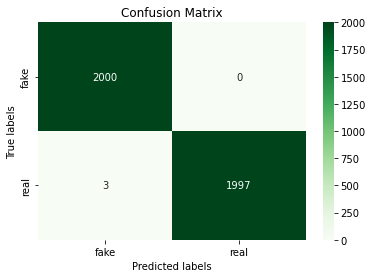

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confmtrx, annot=True, fmt='g', ax=ax, cmap='Greens');  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['fake', 'real']); ax.yaxis.set_ticklabels(['fake', 'real']);